In [1]:
from mhkit.wave import environmental_contours, graphics
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
from os.path import join
from scipy import stats
import pandas as pd
import numpy as np
import json
import csv

# MHKiT Copulas and Comparison to WDRT
This notebook demonstrates how to run and plot the MHKiT copula functions adapted from the WDRT. The notebook starts by importing the NDBC buoy 46050 dataset used in the WDRT toolbox. The notebook then walks through the creation of Gaussian, Gumbel, Clayton, and Rosenblatt. Next, the nonparametric versions of the Gaussian, Clayton, and Gumbel copulas are performed. Following this, the Bivariate KDE method in normal and log are applied to the dataset. Following the calculation of the copulas, the copulas are plotted against the standard IFORM environmental contour for each of the subdivided sections.

## Import Data and Set Contour Parameters
To start we simply read in the Hm0 and Te data from a comma-separated file using the pandas read function. The time difference(dt) between each sample is 3600 seconds so dt is set equal to 3600. We are interested in a 50 year return period to we set period to 50.# MHKiT Copulas and Comparison to WDRT

This notebooks demonstrates how to run and plot the MHKiT copula functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT). The notebook starts by importing the NDBC buoy 46050 dataset used  in the WDRT toolbox. The notebook then walks through the creation of Gaussian, Gumbel, Clayton, and Rosenblatt. Next the nonparametric versions of the Gaussian, Clayton, anf Gumbel copulas are performed. Following this the Bivarate KDE method in normal and log are applied to the dataset. Following the calculation of the copulas the copulas are plotted against the standard IFORM environmental contour for each of the subdivided sections.

## Import Data and Set Contour Parameters

To start we simply read in the Hm0 and Te data from a comma seperated file using the pandas read function. The time difference(`dt`) between each sample is 3600 seconds so dt is set equat to 3600. We are interested in a 50 year return period to we set period to 50.

In [2]:
NDBC46050=pd.read_csv(join('data','wave','NDBC46050.csv'))
Hm0 = NDBC46050.Hm0
Te = NDBC46050.Te

dt=3600 # seconds
period =50 # years

## Standard Environmental Contour

An example of how to calculate environmental contours is included in the `environmental_contours.ipynb` example notebook. Here, we will calculate the 50 year expected sea state to use as a reference in plotting across the different copula groups.

In [3]:
Hm0_contour, Te_contour = environmental_contours.copula(Hm0, Te, dt, period, 'PCA')

## Basic Copulas

We start to calculate the copulas using the MHKiT `environmental_contours` module with the `copula` function. All copula methods are called using one copula function and simply changing the method used. The inputs for the `copula` function are the same as those into the `environmental_contour` with the additional method input. A single string method can be applied if only one copula is of interest or multiple methods can be sent in using a list of strings. Providing multiple methods at once is recommended as it will reduce the computational expense of parameters that are common across the copulas. 

We start by using the default settings for our Gaussian, Gumbel, and Clayton copulas. The `copula` function returns a dictionary with component 'x1' and 'x2' for each method. E.g. if the `copula` function were called on the `'gaussian'` method then copula would return a dictionary with keys `['gaussian_x1', 'gaussian_x2']`. The copula methods are a generalized mathematical method and therefore 'x1' and 'x2' are used in place of Hm0 and Te for the component values. 'x1' refers to the first array passed and 'x2' refers to the second array passed. In the example below 'x1' would refer to the Hm0 component of the coupla and 'x2' would refer to Te. 

Later in the notebook, we compare the MHKiT copula results to WDRT results as a code-to-code verification. For the Rosenblatt copulas, WDRT varied the copula binning slightly from the other methods. Here the Rosenblatt copula is calculated with those parameters and then adding those results to our `copulas` dictionary.



In [4]:
copulas =environmental_contours.copula(Hm0, Te, dt, period, method=['gaussian', 'gumbel', 'clayton'])

# WDRT slightly vaires Rosenblatt copula parameters from the other copula default (vary the defaults here for later comparisons)
rosen =environmental_contours.copula(Hm0, Te, dt, period, method=['rosenblatt'], min_bin_count=50, initial_bin_max_val=0.5, bin_val_size=0.25)
copulas['rosenblatt_x1'] = rosen['rosenblatt_x1'] 
copulas['rosenblatt_x2'] = rosen['rosenblatt_x2'] 

## Nonparametric Copulas

The copula method has three nonparametric methods i.e. one for Gaussian, Clayton, Gumbel methods. All methods are called in the same way as for the basic copulas above. These methods could be called at the same time as the ones above and are only broken out for organization. The nonparametric method takes longer to run than the standard methods. The methods are saved to a new dictionary called `np_copulas`.

In [5]:
np_copulas=environmental_contours.copula(Hm0, Te, dt, period, method=['nonparametric_gaussian','nonparametric_clayton', 'nonparametric_gumbel'])

C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:35: RuntimeWarning: underflow encountered in exp
  FAC = np.exp(-JFAC)/BC
C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:35: RuntimeWarning: underflow encountered in true_divide
  FAC = np.exp(-JFAC)/BC
C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:602: RuntimeWarning: underflow encountered in multiply
  zstar = silverman_transform(bw, gridsize, RANGE) * y
C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\sandbox\nonparametric\kernels.py:520: RuntimeWarning: underflow encountered in exp
  np.exp(-x**2/2.0), h = h, domain = None, norm = 1.0)
C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\sandbox\nonparametric\kernels.py:519: RuntimeWarning: underflow encountered in multiply
  CustomKernel.__init__(self, shape = lambda x: 0.3989422804014327 *
C:\Users\sterl\anaconda3\lib\site-packages\statsmodels\sandbox\nonparametric\kernels.py:204

## Bivariate KDE Copulas

Lastly, the Bivariate KDE method and a logarithmic bivariate KDE method can be run passing the associated method into the same `copula` function we have been using. In this case, we could not run them at the same time because the `bandwidth` was adjusted between the two methods to replicate what was done in the WDRT example. Each of these methods are saved in their respective dictionary.

NOTE: Bivariate KDE copula computation takes a significant amount of time.

In [6]:
kde_copula = environmental_contours.copula(Hm0, Te, dt, period, method=['bivariate_KDE'], bandwidth=[0.23, 0.23])
log_kde_copula = environmental_contours.copula(Hm0, Te, dt, period, method=['bivariate_KDE_log'], bandwidth=[0.02, 0.11])  

C:\Users\sterl\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: underflow encountered in exp
  return np.exp(-x**2/2.0) / _norm_pdf_C
C:\Users\sterl\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:243: RuntimeWarning: underflow encountered in true_divide
  return np.exp(-x**2/2.0) / _norm_pdf_C
c:\users\sterl\codes\mhkit-python\mhkit\wave\environmental_contours.py:1470: RuntimeWarning: underflow encountered in multiply
  ftemp = np.multiply(ftemp,fnew)
c:\users\sterl\codes\mhkit-python\mhkit\wave\environmental_contours.py:1466: RuntimeWarning: underflow encountered in multiply
  fnew = fk*(1/np.transpose(xi[j][i]))


<Figure size 432x288 with 0 Axes>

## Plot Results

In this section we plot the results of the copulas over the underlying data and compare the results to the standard inverse IFORM environmental contour method.

### Plot Standard Copula

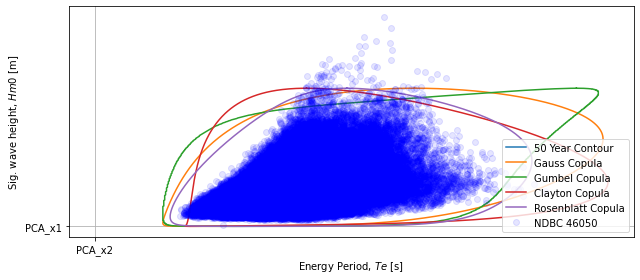

In [7]:
fig, ax = plt.subplots(figsize=(9,4))
component_1 = copulas['gaussian_x1']

Tes=[Te_contour]
Hm0s=[Hm0_contour]
methods=['gaussian', 'gumbel', 'clayton', 'rosenblatt']
for method in methods:   
    Hm0s.append(copulas[f'{method}_x1'])
    Tes.append(copulas[f'{method}_x2'])

ax = graphics.plot_environmental_contour(Te, Hm0, 
                                Tes,
                                Hm0s,
                                data_label='NDBC 46050', 
                                contour_label=['50 Year Contour','Gauss Copula', 'Gumbel Copula', 'Clayton Copula', 'Rosenblatt Copula'],
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                ax=ax)

### Plot Nonparametic Copulas

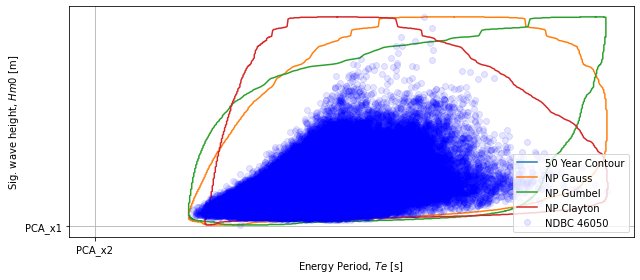

In [8]:
fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(Te, Hm0, 
                                [Te_contour, np_copulas['nonparametric_gaussian_x2'], np_copulas['nonparametric_gumbel_x2'],np_copulas['nonparametric_clayton_x2']],
                                [Hm0_contour, np_copulas['nonparametric_gaussian_x1'], np_copulas['nonparametric_gumbel_x1'],np_copulas['nonparametric_clayton_x1']],                                                                                                                                                                                            
                                data_label='NDBC 46050',                                 
                                contour_label=['50 Year Contour','NP Gauss', 'NP Gumbel', 'NP Clayton'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                ax=ax)

### Plot KDE Copulas

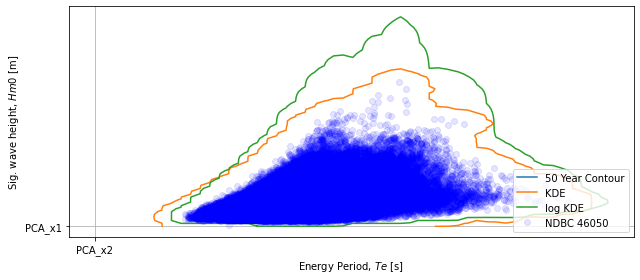

In [9]:
fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(Te, Hm0,                                     
                                [Te_contour, kde_copula['bivariate_KDE_x2'], log_kde_copula['bivariate_KDE_log_x2']],
                                [Hm0_contour, kde_copula['bivariate_KDE_x1'],  log_kde_copula['bivariate_KDE_log_x1']],                                                                                                                                                        
                                data_label='NDBC 46050', 
                                contour_label=['50 Year Contour','KDE', 'log KDE'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                ax=ax)

## Compare WDRT to MHKiT

This section demonstrates that MHKiT exactly matches the results of the WDRT.

### Import Results from WDRT Package

In [10]:
with open('data/wave/WDRT_caluculated_countours.json') as f:
  data = json.load(f)

### Basic Copula

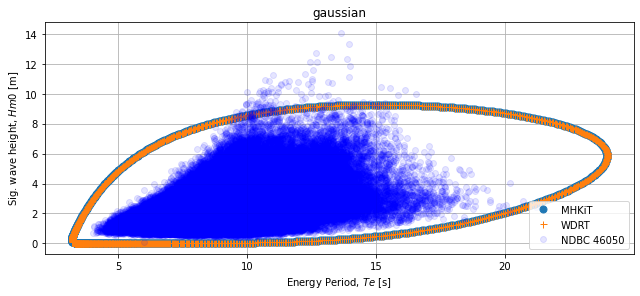

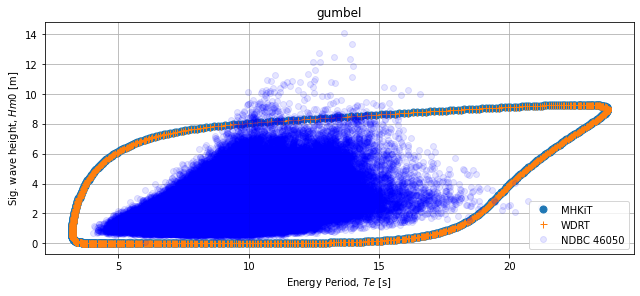

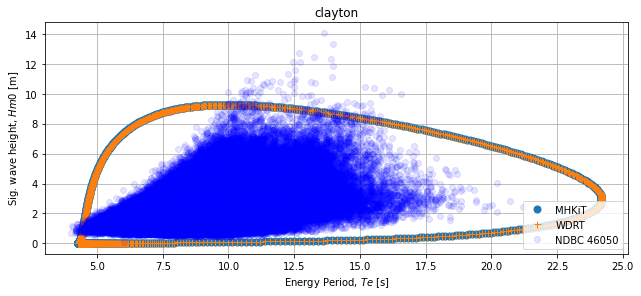

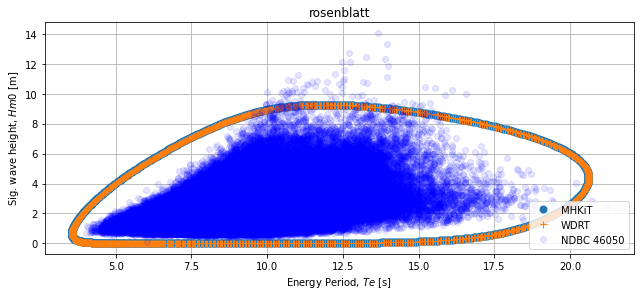

In [11]:
methods=['gaussian', 'gumbel', 'clayton', 'rosenblatt']

for method in methods:
    fig, ax = plt.subplots(figsize=(9,4))
    ax = graphics.plot_environmental_contour(Te, Hm0,                                     
                                [copulas[f'{method}_x2'], data[f'{method}_x2']],
                                [copulas[f'{method}_x1'],  data[f'{method}_x1']],                                                                                                                                                        
                                data_label='NDBC 46050', 
                                contour_label=['MHKiT', 'WDRT'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]',
                                markers=['o','+'],
                                ax=ax)
    plt.title(f'{method}')

### Nonparametric Copulas

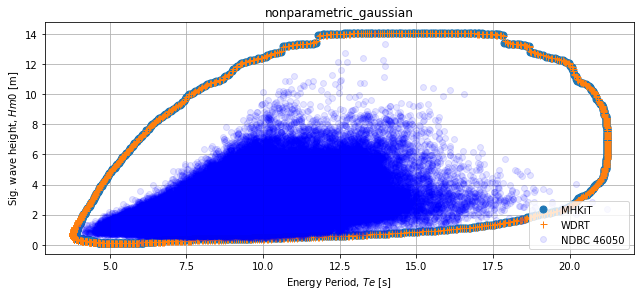

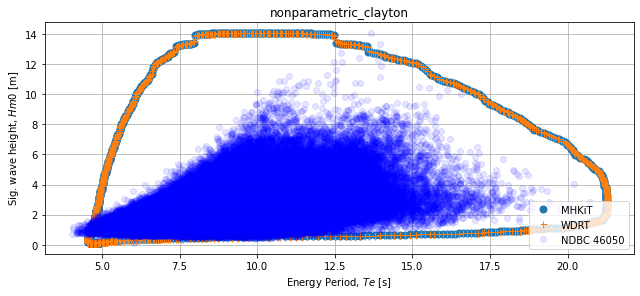

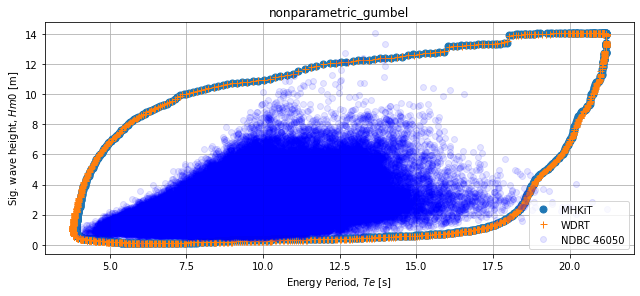

In [12]:
methods=['nonparametric_gaussian','nonparametric_clayton', 'nonparametric_gumbel']

for method in methods:
    fig, ax = plt.subplots(figsize=(9,4))
    ax = graphics.plot_environmental_contour(Te, Hm0,                                     
                                [np_copulas[f'{method}_x2'], data[f'{method}_x2']],
                                [np_copulas[f'{method}_x1'],  data[f'{method}_x1']],                                                                                                                                                        
                                data_label='NDBC 46050', 
                                contour_label=['MHKiT', 'WDRT'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                markers=['o','+'],             
                                ax=ax)
    plt.title(f'{method}')

### KDE Copulas

Text(0.5, 1.0, 'Bivariate KDE')

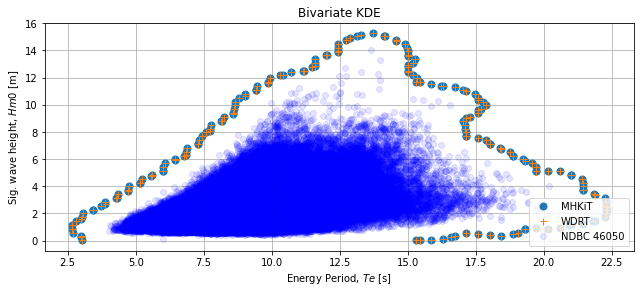

In [13]:
fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(Te, Hm0,                                     
                                [kde_copula['bivariate_KDE_x2'], data['bivariate_KDE_x2']],
                                [kde_copula['bivariate_KDE_x1'],  data['bivariate_KDE_x1']],                                                                                                                                                        
                                data_label='NDBC 46050', 
                                contour_label=['MHKiT', 'WDRT'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                markers=['o','+'],
                                ax=ax)
plt.title('Bivariate KDE')

Text(0.5, 1.0, 'Bivariate KDE Log')

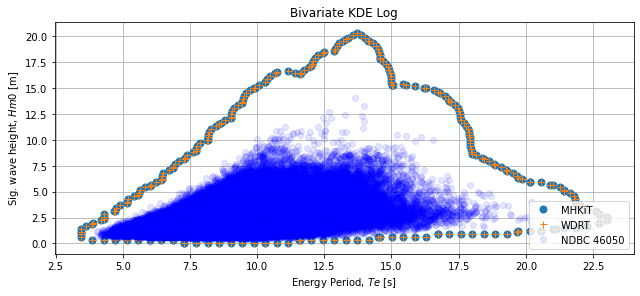

In [14]:
fig, ax = plt.subplots(figsize=(9,4))
ax = graphics.plot_environmental_contour(Te, Hm0,                                     
                                [log_kde_copula['bivariate_KDE_log_x2'], data['bivariate_KDE_log_x2']],
                                [log_kde_copula['bivariate_KDE_log_x1'],  data['bivariate_KDE_log_x1']],                                                                                                                                                        
                                data_label='NDBC 46050', 
                                contour_label=['MHKiT', 'WDRT'],                                         
                                x_label = 'Energy Period, $Te$ [s]',
                                y_label = 'Sig. wave height, $Hm0$ [m]', 
                                markers=['o','+'],
                                ax=ax)
plt.title('Bivariate KDE Log')